# INTRO TO THE PROJECT

In [ ]:
#Download libraries
!pip install scikit-learn
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install scikit-multilearn
!pip install kagglehub
!pip install plotly
!pip install nba_api
!pip install py-stringmatching
!pip install setuptools==58.0.4
!pip install py-stringsimjoin
!pip install torch


# Importing libraries and packages

In [107]:

#  git lfs track "*.csv" 
# git lfs track "notebooks/database.db"

import os
import glob
import kagglehub
import sqlite3
import zipfile
import pandas as pd
from io import BytesIO
from functools import reduce
import sqlite3 as sql
#Data Wrangling

import numpy as np
import pandas as pd

# Linear Models
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression

#Trees
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

# SVM
from sklearn.svm import SVC

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# dimensionality reduction
from sklearn.decomposition import PCA, KernelPCA

#Preprocessing Packages
from sklearn.model_selection import train_test_split

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Model tuning
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, f1_score, recall_score, classification_report, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Aditonal Data Sources
from nba_api.stats.endpoints import TeamInfoCommon
from nba_api.stats.static import teams

#Record Linking
import py_stringmatching as sm
import py_stringsimjoin as ssj

# deep learning
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset


import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# Loading Data Sets
- Load NBA teams information
- Load NBA Shots from 2003-2024 seasons
- Load NBA players information

In [ ]:
# Path to your zip file
current_dir = os.getcwd()
zip_file_path = current_dir + '/../raw-data/nba-shots.zip'
# list to store dataframes from CSV
csv_dataframes = []
# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # Loop through each file in the zip
    for file_name in zip_file.namelist():
        # Check if the file is a CSV
        if file_name.endswith('.csv'):
            # Read the CSV file into a DataFrame
            with zip_file.open(file_name) as file:
                df = pd.read_csv(file)
                csv_dataframes.append(df)  # Store the DataFrame in the dictionary
                print(file_name)

# Now, `csv_dataframes` contains DataFrames for each CSV file
# You can access them by file name, for example:
df = pd.concat(csv_dataframes)
df.head()

In [ ]:
nba_teams_file = current_dir + "/../raw-data/nba-teams.csv"
if not os.path.exists(nba_teams_file):
    print("File is not present, we use an NBA API Fetch Call")
    nba_teams = teams.get_teams()
    # Create a dictionary of team IDs
    team_ids_dict = {team['full_name']: team['id'] for team in nba_teams}
    # Create an empty DataFrame to store the data
    df_teams = pd.DataFrame()
    # Loop through the teams and append to the df
    for team_name, team_id in team_ids_dict.items():
        team_info = TeamInfoCommon(team_id=team_id)
        df_team = team_info.get_data_frames()[0]
        df_team['TeamName'] = team_name  # Adding the team name to the DataFrame
        df_teams = pd.concat([df_teams, df_team], ignore_index=True)
    # Print the combined DataFrame
else:
    print("File is present")
    df_teams = pd.read_csv(nba_teams_file)
df_teams

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + '/../raw-data/'
df_players = pd.read_csv(dir_path + "common_player_info.csv")
df_players.head()

# Data Dictionary

**Self-Explanatory**: **TEAM_NAME**, **PLAYER_NAME**, **POSITION_GROUP**, **POSITION**, **HOME_TEAM**, **AWAY_TEAM**

- **SEASON_1** & **SEASON_2**: Season indicator variables  
- **TEAM_ID**: NBA's unique ID variable of that specific team in their API  
- **PLAYER_ID**: NBA's unique ID variable of that specific player in their API  
- **GAME_DATE**: Date of the game (M-D-Y // Month-Date-Year)  
- **GAME_ID**: NBA's unique ID variable of that specific game in their API  
- **EVENT_TYPE**: Character variable denoting a shot outcome (Made Shot // Missed Shot)  
- **SHOT_MADE**: True/False variable denoting a shot outcome (True // False)  
- **ACTION_TYPE**: Description of shot type (layup, dunk, jump shot, etc.)  
- **SHOT_TYPE**: Type of shot (2PT or 3PT)  
- **BASIC_ZONE**: Name of the court zone the shot took place in  
  - Restricted Area, In the Paint (non-RA), Midrange, Left Corner 3, Right Corner 3, Above the Break, Backcourt  
- **ZONE_NAME**: Name of the side of court the shot took place in  
  - left, left side center, center, right side center, right  
- **ZONE_ABB**: Abbreviation of the side of court  
  - (L), (LC), (C), (RC), (R)  
- **ZONE_RANGE**: Distance range of shot by zones  
  - Less than 8 ft., 8-16 ft. 16-24 ft. 24+ ft.  
- **LOC_X**: X coordinate of the shot in the x, y plane of the court (0, 50)  
- **LOC_Y**: Y coordinate of the shot in the x, y plane of the court (0, 50)  
- **SHOT_DISTANCE**: Distance of the shot with respect to the center of the hoop, in feet  
- **QUARTER**: Quarter of the game  
- **MINS_LEFT**: Minutes remaining in the quarter  
- **SECS_LEFT**: Seconds remaining in minute of the quarter  


# DATA Cleaning, Wrangling and Record Linking

In [ ]:
df["ACTION_TYPE"].unique()

In [ ]:
# inspect the Leagues data set
print("Number of duplicate rows: " + str(df.duplicated().sum()))
print("dtypes:")
print(df.dtypes)
print("----------------------------\nLeagues DF describe:")
print(df.describe())
print("----------------------------\nCheck for Null values:")
print(df.isna().sum())
print("----------------------------\nFirst 5 rows of the dataset")
df.head()

In [ ]:
df_shots_clean = df.drop_duplicates()
df_shots_clean.head()

In [ ]:
df_shots_clean = df_shots_clean[df_shots_clean["ACTION_TYPE"] != "No Shot"]
# Drop NA records
print("Number of rows containing NA values:\n" + str(df_shots_clean.isna().sum()[df_shots_clean.isna().sum() > 0]))
df_shots_clean = df_shots_clean.dropna()
print("Number of rows containing NA values:\n" + str(df_shots_clean.isna().sum()[df_shots_clean.isna().sum() > 0]))
df_shots_clean[df_shots_clean["POSITION_GROUP"].isna() | df_shots_clean["POSITION"].isna()]

# Keep Only current 30 nba teams and get the respective conference for each team

In [ ]:
# Keep only current NBA teams
nba_teams = df_shots_clean[df_shots_clean["SEASON_1"] == 2024].TEAM_NAME.unique()
df_shots_clean = df_shots_clean[df_shots_clean["TEAM_NAME"].isin(nba_teams)]
print(sorted(df_shots_clean.TEAM_NAME.unique()) == sorted(df_teams.TeamName))
# merge on team abbreviation 
df_shots_clean = df_shots_clean.merge(df_teams[['TeamName', 'TEAM_CONFERENCE', "TEAM_ABBREVIATION"]],
                                      left_on='TEAM_NAME', right_on='TeamName', how='inner')
print("Number of rows containing NA values:\n" + str(df_shots_clean.isna().sum()[df_shots_clean.isna().sum() > 0]))
df_shots_clean = df_shots_clean.dropna()
print("Number of rows containing NA values:\n" + str(df_shots_clean.isna().sum()[df_shots_clean.isna().sum() > 0]))
df_shots_clean.head()

In [ ]:
print(df_shots_clean[df_shots_clean["TEAM_CONFERENCE"] == "East"]["TEAM_NAME"].unique())
print(df_shots_clean[df_shots_clean["TEAM_CONFERENCE"] == "West"]["TEAM_NAME"].unique())
# Check that no team from West appears in East conference and vice versa 
print(bool(set(df_shots_clean[df_shots_clean["TEAM_CONFERENCE"] == "East"]["TEAM_NAME"].unique()).intersection(
    set(df_shots_clean[df_shots_clean["TEAM_CONFERENCE"] == "West"]["TEAM_NAME"].unique()))))

In [ ]:
# drop unnecessary columns
df_clean_players = df_players.drop(
    columns=["draft_round", "draft_number", "first_name", "last_name", "display_last_comma_first", "display_fi_last",
             "player_slug", "jersey", "games_played_current_season_flag", "games_played_flag", "playercode",
             "dleague_flag", "nba_flag", "greatest_75_flag", "team_code"]).drop_duplicates()
df_clean_players.head()

# Link NBA Shots DF and Players DF on Player First Name and Last Name basis via Qgram-Jaccard_join

In [ ]:
tok = sm.QgramTokenizer(qval=5, return_set=True)
output_pairs = ssj.jaccard_join(
    df_shots_clean[["PLAYER_ID", "PLAYER_NAME"]].drop_duplicates(subset="PLAYER_ID"),
    df_clean_players,
    'PLAYER_ID',
    'person_id',
    'PLAYER_NAME',
    'display_first_last',
    tok,
    0.7,
    l_out_attrs=['PLAYER_NAME'],
    r_out_attrs=['display_first_last']
)
print("Min sim_score: " + str(output_pairs["_sim_score"].min()))
# since the min score is 1  is no need to do further linking we can just merge
output_pairs

In [ ]:
# perform the merge for linked players records
df_clean_players = df_clean_players[df_clean_players["display_first_last"].isin(output_pairs["r_display_first_last"])]
df_clean_players = df_clean_players.merge(right=output_pairs[["l_PLAYER_ID", "r_person_id"]], left_on="person_id",
                                          right_on="r_person_id", how="inner").drop(
    columns=["r_person_id", "person_id"]).rename(
    columns={"l_PLAYER_ID": "PLAYER_ID", "team_abbreviation": "TEAM_ABBREVIATION", "team_name": "TeamName",
             "team_city": "TEAM_CITY"}).reset_index(drop=True)
# convert birthdate to age
today = pd.to_datetime("2024")
df_clean_players["birthdate"] = pd.to_datetime(df_clean_players["birthdate"])
df_clean_players["age"] = (today - df_clean_players["birthdate"]).dt.days // 365
df_clean_players

# Fill records where players with NA values for team they play

In [ ]:
df_na_players = df_clean_players[df_clean_players["TeamName"].isna()].reset_index(drop=True)
print(len(df_na_players[df_na_players["rosterstatus"] == "Active"]))
# since we have 0 active players with NA values, then we link the latest team from nba shots df to an inactive players
df_na_players = pd.merge(left=df_na_players, right=df_shots_clean[["PLAYER_ID", "TeamName", "GAME_DATE"]].sort_values(
    by="GAME_DATE").drop_duplicates(subset=["PLAYER_ID"], keep="last"), on="PLAYER_ID", how="left").drop(
    columns=["TeamName_x"]).rename(columns={"TeamName_y": "TeamName"}).reset_index(drop=True)
df_na_players = df_na_players.merge(df_teams[["TeamName", "TEAM_ABBREVIATION", "TEAM_CITY"]], on="TeamName",
                                    how="inner").drop(
    columns=["TEAM_ABBREVIATION_x", "TEAM_CITY_x", "GAME_DATE"]).rename(
    columns={"TEAM_ABBREVIATION_y": "TEAM_ABBREVIATION", "TEAM_CITY_y": "TEAM_CITY"}).reset_index(drop=True)
df_na_players

In [ ]:
df_clean_players = df_clean_players.dropna(subset=["TeamName", "TEAM_ABBREVIATION", "TEAM_CITY"])
df_clean_players = pd.concat([df_clean_players, df_na_players], ignore_index=True).dropna()
df_clean_players

# Convert Active-Inactive variable to boolean 1/0

In [ ]:
df_clean_players["rosterstatus"] = df_clean_players["rosterstatus"].map(
    lambda record: 1 if record == "Active" else (0 if record == "Inactive" else None))
df_active_players = df_clean_players[df_clean_players["rosterstatus"] == 1]
df_active_players


In [ ]:
# update the shots df to have active/inactive variable for players
df_shots_clean = pd.merge(left=df_shots_clean, right=df_clean_players[["rosterstatus", "PLAYER_ID"]], on="PLAYER_ID")
df_shots_clean = df_shots_clean.drop(columns=["TeamName"])
# make a variable is_home or not whether team played was home or away team
df_shots_clean.head()

In [ ]:
print(df_shots_clean["SHOT_TYPE"].unique())
# convert SHOT_TYPE to have boolean 1/0 variable for 3PT and 2PT shots respectively
df_shots_clean["SHOT_TYPE"] = df_shots_clean["SHOT_TYPE"].map(lambda x: 1 if x == "3PT Field Goal" else 0)
df_shots_clean = df_shots_clean.rename(columns={"SHOT_TYPE": "IS_3PT"})
# make a variable is_home or not whether team played was home or away team
df_shots_clean["is_home"] = (df_shots_clean["HOME_TEAM"] == df_shots_clean["TEAM_ABBREVIATION"]).astype(int)
df_shots_clean.head()

In [ ]:
# we have at least 1.3m records of shots for currently active players
df_shots_clean[df_shots_clean["rosterstatus"] == 1]

In [ ]:
conn = sql.connect("database.db")
df_shots_clean.to_sql("nba", conn, if_exists="replace", index=False)

# Exploratory Data Analysis (EDA)
- Jump Shot accuracy by Zone (2pt and 3pt)
- Accuracy by action type (done)
- Most efficient players + shot distribution heat map
- Home vs. Performance for teams
- Time trend in accuracy, points,  action type, etc

# Accuracy by action type

In [ ]:
action_types_p = df_shots_clean.ACTION_TYPE.unique()
action_types_sql = pd.read_sql("SELECT DISTINCT ACTION_TYPE from nba", conn)
print("Pandas and SQL versions are identical: " + str(len(action_types_p) == len(action_types_sql)))
action_types_p

In [ ]:
query = '''
SELECT ACTION_TYPE, COUNT(*) AS count
FROM nba
GROUP BY ACTION_TYPE
ORDER BY count DESC
'''
top_action_types_df = pd.read_sql(query, conn)
# top_action_types_df = df_shots_clean.groupby("ACTION_TYPE").agg(count=("ACTION_TYPE", "count")).sort_values(by="count",  ascending=False).reset_index()
top_action_types_df = top_action_types_df[
    top_action_types_df["count"] >= top_action_types_df["count"].quantile(0.75)].reset_index(drop=True)
action_types_75_p = df_shots_clean[df_shots_clean["ACTION_TYPE"].isin(top_action_types_df["ACTION_TYPE"])][
    ["ACTION_TYPE", "SHOT_MADE", "SHOT_DISTANCE"]]
action_types_75_p = action_types_75_p.groupby("ACTION_TYPE").agg(accuracy=("SHOT_MADE", "mean"),
                                                                 avg_distance=("SHOT_DISTANCE", "mean"),
                                                                 count=("SHOT_MADE", "count")).reset_index()
action_types_75_p

In [ ]:
# Bubble Chart (Scatter Plot with Bubble Size)
fig = go.Figure()
fig.update_layout(width=1400, height=800, title="NBA Players Action Type Accuracy, Shot Distance and Attempt Count",
                  xaxis=dict(
                      title="Average Distance from the basket",
                      gridcolor="white",
                      gridwidth=2,
                  ),
                  yaxis=dict(
                      title="Accuracy (%)",
                      gridcolor="white",
                      gridwidth=2,
                  ),
                  )
fig.add_trace(
    go.Scatter(
        x=action_types_75_p["avg_distance"],
        y=action_types_75_p["accuracy"] * 100,
        mode="markers",
        marker=dict(
            size=action_types_75_p["count"],
            sizemode="area",
            sizeref=100,
            color=action_types_75_p["count"],
            colorscale="Viridis",
            showscale=True,
            line_color='rgb(140, 140, 170)',
            colorbar_title='Shots<br>Count',
        ),
        text=action_types_75_p["ACTION_TYPE"],
        hovertemplate=(
                "Action Type: %{text}<br>" +
                "Accuracy: %{y:.2f}<br>" +
                "Average Distance: %{x:.2f}<br>" +
                "Attempt Count: %{marker.size:.0f}"
        ),
        name="Action Types"
    )
)

# Comparison of 2pt vs. 3pt shots over time

In [ ]:
query = '''
SELECT TEAM_NAME, SEASON_1 as season, IS_3PT, AVG(SHOT_MADE)*100 as accuracy, TEAM_CONFERENCE as conference
FROM nba
GROUP BY SEASON_1, TEAM_CONFERENCE, TEAM_NAME, IS_3PT
'''
# Comparison of 2pt vs. 3pt shots over time
shot_type_df = pd.read_sql(query, conn)
shot_type_df

In [ ]:
rolling_mean = shot_type_df.copy()
rolling_mean['rolling_mean'] = rolling_mean['accuracy'].transform(
    lambda x: x.rolling(window=3, center=False).mean()
)
rolling_mean = rolling_mean.dropna(subset=['rolling_mean'])
rolling_mean

In [ ]:
plt.figure(figsize=(25, 6))
#TODO: Perform a ADF test
sns.boxplot(data=shot_type_df, x="season", y="accuracy", hue="conference", gap=.1)

plt.figure(figsize=(25, 6))
# Plot the rolling mean
sns.lineplot(data=rolling_mean, x="season", y="rolling_mean", style=None, linestyle='--',
             markers=False, label="Rolling Mean")
# Plot the League (West and East)
sns.lineplot(data=shot_type_df, x="season", y="accuracy", hue="conference", style=None, linestyle='-', markers=False,
             errorbar=None)
plt.legend(title="Conference Accuracy %")
plt.title("Accuracy of 2PT and 3PT Shots Combined West vs.East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))

# Plot for East Conference
plt.figure(figsize=(26, 10))
sns.lineplot(data=shot_type_df[shot_type_df["conference"] == "East"], x="season", y="accuracy", hue="TEAM_NAME",
             style=None, linestyle='-', markers=False,
             errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 2PT and 3PT Shots Combined by Teams in East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))
# Plot the rolling mean
sns.lineplot(data=rolling_mean[rolling_mean["conference"] == "East"], x="season", y="rolling_mean", style=None,
             linestyle='--',
             markers=False, label="Rolling Mean")
# Plot for West Conference
plt.figure(figsize=(26, 10))
sns.lineplot(data=shot_type_df[shot_type_df["conference"] == "West"], x="season", y="accuracy", hue="TEAM_NAME",
             style=None, linestyle='-', markers=False,
             errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 2PT and 3PT Shots Combined by Teams in West Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))
# Plot the rolling mean
sns.lineplot(data=rolling_mean[rolling_mean["conference"] == "West"], x="season", y="rolling_mean", style=None,
             linestyle='--',
             markers=False, label="Rolling Mean")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(25, 6))
sns.lineplot(data=shot_type_df[shot_type_df["IS_3PT"] == 1], x="season", y="accuracy",
             hue="conference", style=None, linestyle='-', markers=False,
             errorbar=None)
plt.legend(title="Conference")
plt.title("Accuracy of 3PT Shots West vs.East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))

plt.figure(figsize=(25, 6))
sns.lineplot(
    data=shot_type_df[(shot_type_df["conference"] == "East") & (shot_type_df["IS_3PT"] == 1)],
    x="season", y="accuracy", hue="TEAM_NAME", style=None, linestyle='-', markers=False,
    errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 3PT Shots by Teams in East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))

plt.figure(figsize=(25, 6))
sns.lineplot(
    data=shot_type_df[(shot_type_df["conference"] == "West") & (shot_type_df["IS_3PT"] == 1)],
    x="season", y="accuracy", hue="TEAM_NAME", style=None, linestyle='-', markers=False,
    errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 3PT Shots by Teams in West Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))
plt.show()

In [ ]:

plt.figure(figsize=(25, 6))
sns.lineplot(data=shot_type_df[shot_type_df["IS_3PT"] == 0], x="season", y="accuracy",
             hue="conference", style=None, linestyle='-', markers=False,
             errorbar=None)
plt.legend(title="Conference")
plt.title("Accuracy of 2PT Shots West vs.East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))

plt.figure(figsize=(25, 6))
sns.lineplot(
    data=shot_type_df[(shot_type_df["conference"] == "East") & (shot_type_df["IS_3PT"] == 0)],
    x="season", y="accuracy", hue="TEAM_NAME", style=None, linestyle='-', markers=False,
    errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 2PT Shots by Teams in East Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))

plt.figure(figsize=(25, 6))
sns.lineplot(
    data=shot_type_df[(shot_type_df["conference"] == "West") & (shot_type_df["IS_3PT"] == 0)],
    x="season", y="accuracy", hue="TEAM_NAME", style=None, linestyle='-', markers=False,
    errorbar=None)
plt.legend(loc='upper left', title="Team Name", bbox_to_anchor=(1, 1))
plt.title("Accuracy of 2PT Shots by Teams in West Conference")
plt.ylabel("Accuracy Score in %")
plt.xlabel("NBA Season")
plt.xticks(rotation=30)
plt.gca().set_xticks(shot_type_df['season'].unique())
plt.gca().set_xticklabels(sorted(shot_type_df['season'].unique()))
plt.show()

In [ ]:
df_shots_clean.head()

# Predictive Models
- Predict

In [70]:

#TODO: Make
query = '''
WITH PlayersShotsStats AS (
    SELECT 
        PLAYER_NAME,
        SEASON_1,
        GAME_ID,
        POSITION,
        POSITION_GROUP,
        IS_HOME,
        SUM(CASE 
            WHEN IS_3PT = 0 AND SHOT_MADE = True THEN 2
            WHEN IS_3PT = 1 AND SHOT_MADE = True THEN 3
            ELSE 0 
        END) AS PTS, -- count points scored by each player
        COUNT(SHOT_MADE) AS FGA, -- Field Goal Attempts
        SUM(CASE WHEN SHOT_MADE = True THEN 1 ELSE 0 END) AS FGM, -- Field Goals Made
        SUM(CASE WHEN IS_3PT = 1 THEN 1 ELSE 0 END) AS threePA, -- 3PT Attempts
        SUM(CASE WHEN IS_3PT = 0 THEN 1 ELSE 0 END) AS twoPA, -- 2PT Attempts
        SUM(CASE WHEN IS_3PT = 1 AND SHOT_MADE = True THEN 1 ELSE 0 END) AS threePM, -- 3PT Made
        SUM(CASE WHEN IS_3PT = 0 AND SHOT_MADE = True THEN 1 ELSE 0 END) AS twoPM, -- 2PT Made
        AVG(SHOT_DISTANCE) AS avgShotDist, -- Average Shot Distance
        PLAYER_ID
    FROM nba
    GROUP BY PLAYER_NAME, SEASON_1, GAME_ID
), metrics AS (
    SELECT 
        PLAYER_NAME,
        POSITION,
        POSITION_GROUP,
        SEASON_1,
        GAME_ID,
        IS_HOME,
        PTS,
        FGA,
        FGM,
        threePA,
        threePM,
        twoPA,
        twoPM,
        avgShotDist,
        -- Field Goal Percentage (FG%)
        CASE WHEN FGA > 0 THEN CAST(FGM AS FLOAT) / FGA * 100 ELSE 0 END AS FG_Percentage,
        -- Three-Point Percentage (3P%)
        CASE WHEN threePA > 0 THEN CAST(threePM AS FLOAT) / threePA * 100 ELSE 0 END AS threePM_Percentage,
        -- Two-Point Percentage (2P%)
        CASE WHEN twoPA > 0 THEN CAST(twoPM AS FLOAT) / twoPA * 100 ELSE 0 END AS twoPM_Percentage,
        -- Effective Field Goal Percentage (eFG%)
        CASE WHEN FGA > 0 THEN (CAST(FGM AS FLOAT) + 0.5 * threePM) / FGA * 100 ELSE 0 END AS eFG_Percentage,
        -- Points Per Shot Attempt
        CASE WHEN FGA > 0 THEN CAST(PTS AS FLOAT) / FGA ELSE 0 END AS PTS_per_Shot,
        PLAYER_ID
    FROM PlayersShotsStats
)
SELECT *
FROM metrics m
WHERE PLAYER_NAME IN (
    SELECT PLAYER_NAME
    FROM PlayersShotsStats
    GROUP BY PLAYER_NAME
    HAVING COUNT(DISTINCT GAME_ID) > 5
)
ORDER BY m.SEASON_1, m.GAME_ID;
'''
# Players KPI's over 2004-2024 seasons
players_stats = pd.read_sql(query, conn)
players_stats

,PLAYER_NAME,POSITION,POSITION_GROUP,SEASON_1,GAME_ID,IS_HOME,PTS,FGA,FGM,threePA,threePM,twoPA,twoPM,avgShotDist,FG_Percentage,threePM_Percentage,twoPM_Percentage,eFG_Percentage,PTS_per_Shot,PLAYER_ID
0,Aaron McKie,SF,F,2004,20300001,1,8,7,3,2,2,5,1,13.571429,42.857143,100.000000,20.000000,57.142857,1.142857,243
1,Allen Iverson,SG,G,2004,20300001,1,21,25,9,11,3,14,6,17.640000,36.000000,27.272727,42.857143,42.000000,0.840000,947
2,Amal McCaskill,C,C,2004,20300001,1,2,1,1,0,0,1,1,3.000000,100.000000,0.000000,100.000000,100.000000,2.000000,1043
3,Brian Grant,C,C,2004,20300001,0,8,5,4,0,0,5,4,2.800000,80.000000,0.000000,80.000000,80.000000,1.600000,258
4,Derrick Coleman,C,C,2004,20300001,1,7,8,3,2,1,6,2,12.875000,37.500000,50.000000,33.333333,43.750000,0.875000,934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383754,LeBron James,PF,F,2024,22301230,1,22,12,9,4,4,8,5,12.666667,75.000000,100.000000,62.500000,91.666667,1.833333,2544
383755,Naji Marshall,SF,F,2024,22301230,0,3,2,1,1,1,1,0,11.500000,50.000000,100.000000,0.000000,75.000000,1.500000,1630230
383756,Rui Hachimura,PF,F,2024,22301230,1,11,9,5,3,1,6,4,12.777778,55.555556,33.333333,66.666667,61.111111,1.222222,1629060
383757,Trey Murphy III,SF,F,2024,22301230,0,12,13,5,7,2,6,3,15.461538,38.461538,28.571429,50.000000,46.153846,0.923077,1630530


In [71]:
players_stats = pd.merge(left=players_stats, right=df_active_players[["PLAYER_ID", "age"]], on="PLAYER_ID")
players_stats.head(2)

,PLAYER_NAME,POSITION,POSITION_GROUP,SEASON_1,GAME_ID,IS_HOME,PTS,FGA,FGM,threePA,...,twoPA,twoPM,avgShotDist,FG_Percentage,threePM_Percentage,twoPM_Percentage,eFG_Percentage,PTS_per_Shot,PLAYER_ID,age
0,Udonis Haslem,PF,F,2004,20300001,0,2,5,1,0,...,5,1,5.0,20.0,0.0,20.0,20.0,0.4,2617,43
1,Udonis Haslem,PF,F,2004,20300004,0,6,4,3,0,...,4,3,6.0,75.0,0.0,75.0,75.0,1.5,2617,43


In [72]:
# create different rolling averages for k last games 
players_stats_model1 = players_stats
rolling_games = list(range(4, 11))


def calc_rolling_games(k):
    print(k)
    players_stats_model1[f'FG%_rolling_{k}_games'] = players_stats_model1.groupby('PLAYER_NAME')[
        'FG_Percentage'].transform(
        lambda x: x.rolling(window=k, min_periods=1).mean())
    # players_stats_model1[f'threePM%_rolling_{k}_games'] = players_stats_model1.groupby('PLAYER_NAME')[
    #     'threePM_Percentage'].transform(
    #     lambda x: x.rolling(window=k, min_periods=1).mean())
    # players_stats_model1[f'twoPM%_rolling_{k}_games'] = players_stats_model1.groupby('PLAYER_NAME')[
    #     'twoPM_Percentage'].transform(
    #     lambda x: x.rolling(window=k, min_periods=1).mean())
    # players_stats_model1[f'eFG%_rolling_{k}_games'] = players_stats_model1.groupby('PLAYER_NAME')[
    #     'eFG_Percentage'].transform(
    #     lambda x: x.rolling(window=k, min_periods=1).mean())
    # players_stats_model1[f'PTS_per_shot_rolling_{k}_games'] = players_stats_model1.groupby('PLAYER_NAME')[
    #     'PTS_per_Shot'].transform(
    #     lambda x: x.rolling(window=k, min_periods=1).mean())


for k in rolling_games:
    calc_rolling_games(k)

4
5
6
7
8
9
10


In [73]:
# create different rolling averages for k last seasons 
rolling_seasons = list(range(2, 5))

def calc_rolling_seasons(j):
    print(j)
    players_stats_model1[f'FG%_rolling_{j}_seasons'] = players_stats_model1.groupby(["PLAYER_NAME", "SEASON_1"])[
        'FG_Percentage'].transform(lambda x: x.rolling(window=j, min_periods=1).mean())
    # players_stats_model1[f'threePM%_rolling_{j}_seasons'] = players_stats_model1.groupby(["PLAYER_NAME", "SEASON_1"])[
    #     'threePM_Percentage'].transform(lambda x: x.rolling(window=j, min_periods=1).mean())
    # players_stats_model1[f'twoPM%_rolling_{j}_seasons'] = players_stats_model1.groupby(["PLAYER_NAME", "SEASON_1"])[
    #     'twoPM_Percentage'].transform(lambda x: x.rolling(window=j, min_periods=1).mean())
    # players_stats_model1[f'eFG%_rolling_{j}_seasons'] = players_stats_model1.groupby(["PLAYER_NAME", "SEASON_1"])[
    #     'eFG_Percentage'].transform(lambda x: x.rolling(window=j, min_periods=1).mean())
    # players_stats_model1[f'PTS_per_shot_rolling_{j}_seasons'] = \
    #     players_stats_model1.groupby(["PLAYER_NAME", "SEASON_1"])[
    #         'PTS_per_Shot'].transform(lambda x: x.rolling(window=j, min_periods=1).mean())


for j in rolling_seasons:
    calc_rolling_seasons(j)

2
3
4


In [74]:
players_stats_model1 = players_stats_model1.drop(columns=["POSITION", "POSITION_GROUP", "PLAYER_NAME", "SEASON_1","IS_HOME", "PTS", "FGA", "FGM", "threePA", "threePM", "twoPA", "twoPM", "avgShotDist", "threePM_Percentage", "twoPM_Percentage", "PTS_per_Shot", "FG_Percentage", "eFG_Percentage"])
players_stats_model1.head()

,GAME_ID,PLAYER_ID,age,FG%_rolling_4_games,FG%_rolling_5_games,FG%_rolling_6_games,FG%_rolling_7_games,FG%_rolling_8_games,FG%_rolling_9_games,FG%_rolling_10_games,FG%_rolling_2_seasons,FG%_rolling_3_seasons,FG%_rolling_4_seasons
0,20300001,2617,43,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
1,20300004,2617,43,47.500000,47.500000,47.500000,47.500000,47.500000,47.500000,47.500000,47.500000,47.500000,47.500000
2,20300020,2617,43,48.333333,48.333333,48.333333,48.333333,48.333333,48.333333,48.333333,62.500000,48.333333,48.333333
3,20300045,2617,43,52.916667,52.916667,52.916667,52.916667,52.916667,52.916667,52.916667,58.333333,63.888889,52.916667
4,20300051,2617,43,58.630952,50.904762,50.904762,50.904762,50.904762,50.904762,50.904762,54.761905,53.174603,58.630952


# Feature Engineering/Extraction

In [75]:
# These columns will be dropped and will not be used for training the model
# Some features seem intuitevly irrelevant, some might leak some information to the model and that 
# the rest might be redundant which can affect inference
# EVENT_TYPE is another example that leaks information (missed shot or made shot)
# This will be focused on predicting weather a player will be able to make a shot or not given specific features

# TEAM_ABBREVIATION: Using team id instead of abbr
# TEAM_NAME: Using team id instead
# rosterstatus: Determines wether a player is active or not. Doesn't matter since we need to predict on test weather a player will be able to make a shot or not
# IS_3PT: Leaks wether a player will make a shot or no, e.g 3_PT is 1 shot is made
# SHOT_MADE: The variable will be prediciting 
# EVENT_TYPE: Leaks wether a player will make a shot or not e.g Missed Shot, Made Shot
# GAME_ID: Just a unique identifier for the game probably don't need
# GAME_DATE: Time can help maybe a player improves over time, but hot encoding would be tedious
# SEASON_2: Just keeping SEASON_1 redandunt information 
# POSITION_GROUP: Already have position
# ZONE_ABB: Already have ZONE
# PLAYER_NAME: using PLAYER_ID which will be hot encoded
# AWAY_TEAM: Might be same as TEAM_NAME
# HOME_TEAM: Using is_home instead

df_shots_clean_drop = ["TEAM_ABBREVIATION", "TEAM_NAME",
                       "rosterstatus", 
                       "EVENT_TYPE", "GAME_DATE", 
                       "SEASON_2", "POSITION_GROUP", "ZONE_ABB",
                       "PLAYER_NAME", "AWAY_TEAM", "HOME_TEAM"]

one_hot_encoding_columns = ["SEASON_1","TEAM_ID", "PLAYER_ID", "ACTION_TYPE", "BASIC_ZONE", "PLAYER_ID", 
                            "ZONE_RANGE", "TEAM_CONFERENCE", "ZONE_NAME", "POSITION"]

In [76]:
df_pre_train = df_shots_clean.drop(df_shots_clean_drop, axis=1)
#TODO: Havee an accuracy moving averages for players as additional feature for predicting based on k last seasons or games respectively
df_pre_train = df_pre_train.merge(players_stats_model1, on=["PLAYER_ID", "GAME_ID"]).reset_index(drop=True)
df_pre_train.head()

,SEASON_1,TEAM_ID,PLAYER_ID,POSITION,GAME_ID,SHOT_MADE,ACTION_TYPE,IS_3PT,BASIC_ZONE,ZONE_NAME,...,FG%_rolling_4_games,FG%_rolling_5_games,FG%_rolling_6_games,FG%_rolling_7_games,FG%_rolling_8_games,FG%_rolling_9_games,FG%_rolling_10_games,FG%_rolling_2_seasons,FG%_rolling_3_seasons,FG%_rolling_4_seasons
0,2015,1610612747,203903,PG,21401211,False,Jump Shot,1,Above the Break 3,Center,...,44.580201,43.899455,39.360657,42.309134,46.742715,48.215746,48.394172,47.493734,46.477304,44.580201
1,2015,1610612747,203903,PG,21401211,False,Running Layup Shot,0,Restricted Area,Center,...,44.580201,43.899455,39.360657,42.309134,46.742715,48.215746,48.394172,47.493734,46.477304,44.580201
2,2015,1610612747,203903,PG,21401211,True,Jump Shot,1,Above the Break 3,Center,...,44.580201,43.899455,39.360657,42.309134,46.742715,48.215746,48.394172,47.493734,46.477304,44.580201
3,2015,1610612747,203903,PG,21401211,True,Jump Shot,0,Mid-Range,Right Side Center,...,44.580201,43.899455,39.360657,42.309134,46.742715,48.215746,48.394172,47.493734,46.477304,44.580201
4,2015,1610612747,203903,PG,21401211,False,Jump Shot,0,In The Paint (Non-RA),Right Side,...,44.580201,43.899455,39.360657,42.309134,46.742715,48.215746,48.394172,47.493734,46.477304,44.580201


In [77]:
df_pre_train["SHOT_MADE"] = df_pre_train["SHOT_MADE"].astype(int)

In [78]:
# check if labels are inbalanced
df_pre_train["SHOT_MADE"].value_counts()

SHOT_MADE
0    731736
1    647103
Name: count, dtype: int64

# Training With Decision Tree Algorithms
## Filter Out Players

We filter out players that played at least a 1000 games. This gives enough data about each player
for train/test split.

In [79]:
player_number_of_games = df_shots_clean.groupby("PLAYER_ID").size().sort_values()
mask = player_number_of_games >= 1000
players_to_be_trained = player_number_of_games[mask]

In [80]:
# We'll do 80/20 split for each player this means we'll train the algorithm on 80% of the games that the player attended
# and test our algorithm on the remaining 20%
train_df = []
test_df = []

train = 0.8
# loop through each player
for player in players_to_be_trained.index:
    mask = df_pre_train['PLAYER_ID'] == player
    player_df = df_pre_train[mask].sample(frac=1) # shuffle the data
    num_of_rows_to_select = int(len(player_df) * train)
    train_subset = player_df.iloc[:num_of_rows_to_select]
    test_subset = player_df.iloc[num_of_rows_to_select:]
    train_df.append(train_subset)
    test_df.append(test_subset)

In [81]:
train_df = pd.concat(train_df)
test_df = pd.concat(test_df)

In [82]:
from pandas import SparseDtype

# One hot encoding
train_df = pd.get_dummies(train_df, columns=one_hot_encoding_columns, dtype=SparseDtype("int", 0))
test_df = pd.get_dummies(test_df, columns=one_hot_encoding_columns, dtype=SparseDtype("int", 0))

# Align train and test columns
train_df, test_df = train_df.align(test_df, join="outer", axis=1, fill_value=0)


In [83]:
train_df.shape, test_df.shape

((1060727, 1337), (265326, 1337))

In [84]:
from scipy.sparse import csr_matrix

x_train, y_train = train_df.drop("SHOT_MADE", axis=1), train_df["SHOT_MADE"]
x_test, y_test = test_df.drop("SHOT_MADE", axis=1), test_df["SHOT_MADE"]

x_train_ = csr_matrix(x_train.values)
x_test = csr_matrix(x_test.values)

In [123]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import VotingClassifier
scoring = "accuracy"

models = []
max_iter = 2000

models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(("SVM", SVC(kernel="linear")))
models.append(("AdaBoostClassifier", AdaBoostClassifier()))
models.append(("GradientBoostingClassifier", GradientBoostingClassifier()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("ExtraTreesClassifier", ExtraTreesClassifier()))
models.append(("LogisticRegression", LogisticRegression(max_iter=max_iter, solver='saga')))
models.append(("Lasso (Logistic Regression)", LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=max_iter)))
models.append(("RidgeClassifier", RidgeClassifier(alpha=1.0, max_iter=max_iter)))
models.append(("ElasticNet (Logistic Regression)", LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0, max_iter=max_iter)))


In [124]:
%%time
results = []
names = []

cross_validation_subset_x = x_train[:10000]
cross_validation_subset_y = y_train[:10000]
# 
# for name, model in models:
#     kfold = KFold(n_splits=10)
#     cv_results = cross_val_score(model, cross_validation_subset_x, cross_validation_subset_y, cv=kfold, scoring=scoring, n_jobs=-1)
#     results.append(cv_results)
#     names.append(name)
#     print(f"{name}: {cv_results.mean()} {cv_results.std()}")

CPU times: user 21.6 ms, sys: 4.23 ms, total: 25.8 ms
Wall time: 24.7 ms


In [125]:
# Fit a random forest classifier and check the confusion matrix
# currently fitting this on a subset of the data to reduce compute resources
# until we try neural networks and then fit the best model on the train data

model = RandomForestClassifier()
model.fit(cross_validation_subset_x, cross_validation_subset_y)

preds = model.predict(x_test[:1000])
y_test_subset = y_test[:1000]

print(confusion_matrix(y_test_subset, preds))
print(classification_report(y_test_subset, preds))

[[341 162]
 [190 307]]
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       503
           1       0.65      0.62      0.64       497

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000


# Applying PCA To Our Data

As you can see above we have 800+ features after we applied one hot encoding to the data. We have 3,000,000+ rows which can make this computationally inefficient and can affect training. We'll try to capture most of the variance and hopefully reduce our data data then apply
cross validation.

In [126]:
%%time
scaler = StandardScaler(with_mean=False)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

CPU times: user 7.58 s, sys: 7.98 s, total: 15.6 s
Wall time: 18.1 s


CPU times: user 1min 45s, sys: 40.8 s, total: 2min 26s
Wall time: 14.1 s


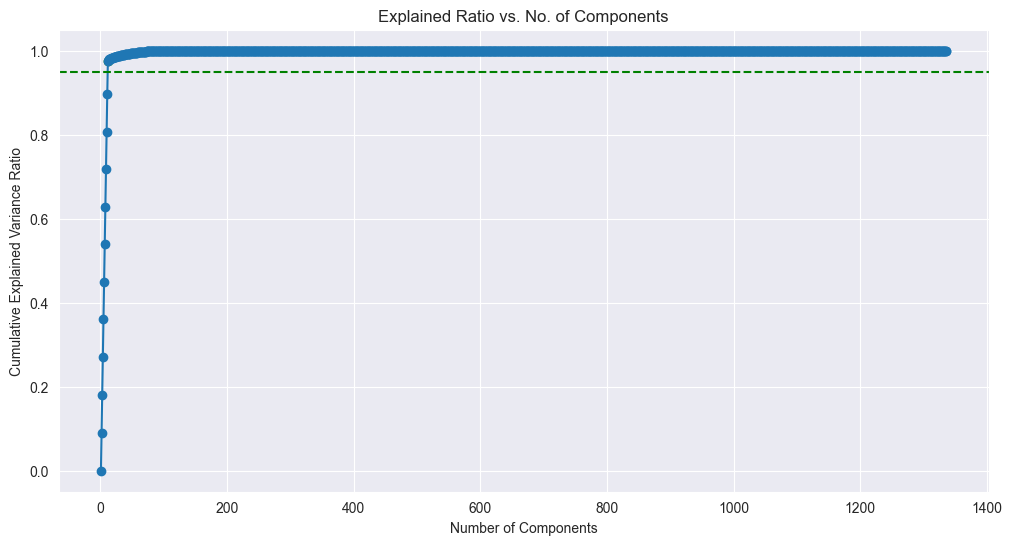

In [127]:
%%time
from sklearn.decomposition import TruncatedSVD
cv_x_train_scaled = scaler.transform(cross_validation_subset_x)

# pca = KernelPCA(kernel="rbf")
svd = TruncatedSVD(n_components=train_df.shape[1]-1)
# pca = PCA()
svd.fit_transform(cv_x_train_scaled)
# eigenvalues = pca.eigenvalues_

# Explained Variance Ratio
# ratio = eigenvalues / np.sum(eigenvalues)
ratio = svd.explained_variance_ratio_

cum_sum = np.cumsum(ratio)
    

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cum_sum) + 1), cum_sum, marker='o', linestyle='-')
plt.axhline(y=0.95, color='g', linestyle='--', label="95% Explained Variance")
# 95% thresholds
components_95 = np.argmax(cum_sum >= 0.95) + 1
plt.scatter(components_95, cum_sum[components_95 - 1], color='green', label=f"95%: {components_95} Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Ratio vs. No. of Components")
plt.grid(True)


In [128]:
cum_sum[:20]

array([2.07027461e-04, 9.08394918e-02, 1.80954465e-01, 2.70738396e-01,
       3.60444428e-01, 4.50056764e-01, 5.39618836e-01, 6.29119222e-01,
       7.18372010e-01, 8.07487275e-01, 8.96502415e-01, 9.76439260e-01,
       9.78217506e-01, 9.79543425e-01, 9.80286164e-01, 9.80958334e-01,
       9.81592531e-01, 9.82191500e-01, 9.82788052e-01, 9.83353103e-01])

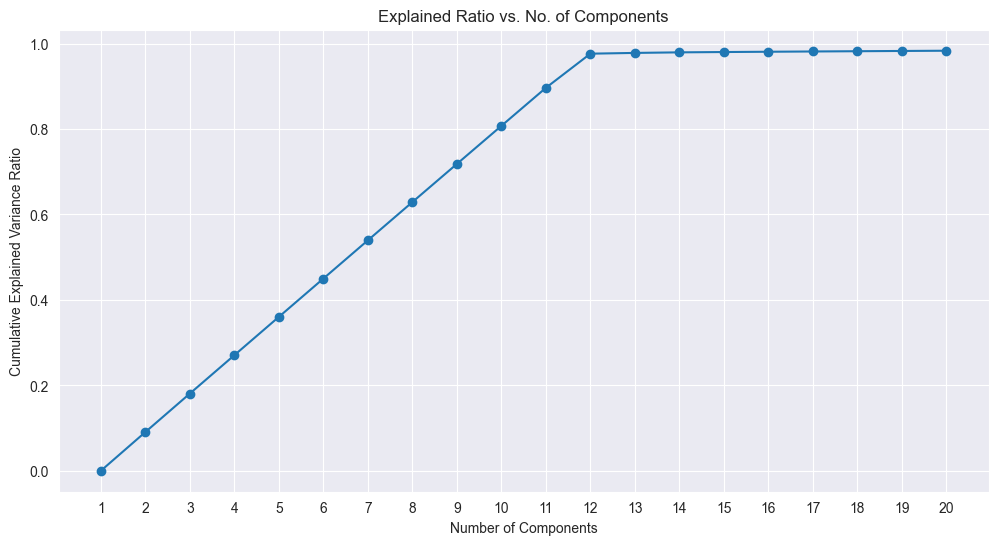

In [129]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cum_sum[:20])+1), cum_sum[:20], marker='o', linestyle='-')
plt.xticks(range(1, len(cum_sum[:20]) + 1))
plt.xticks()
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Explained Ratio vs. No. of Components")
plt.grid(True)

In [130]:
%%time
# As we can see above we can reduce the data to 12 components and have more than 95% of the variance explained
# so we'll proceed with


# pca = KernelPCA(kernel="rbf")
svd = TruncatedSVD(n_components=12)
svd.fit(x_train_scaled)

x_train_svd, x_test_svd = svd.transform(x_train_scaled), svd.transform(x_test_scaled)

CPU times: user 3min 22s, sys: 54.8 s, total: 4min 17s
Wall time: 26.6 s


In [131]:
%%time
cross_validation_subset_x_svd = x_train_svd[:10000]

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, cross_validation_subset_x_svd, cross_validation_subset_y, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean()} {cv_results.std()}")

DecisionTreeClassifier: 0.5448 0.02457966639317952
SVM: 0.5772 0.028606992152269327
AdaBoostClassifier: 0.6 0.04632493928760189
GradientBoostingClassifier: 0.6058 0.0423740486618874
RandomForestClassifier: 0.5806 0.027778408881719605
ExtraTreesClassifier: 0.5779 0.015488382743204647
LogisticRegression: 0.5857 0.029506101064017246
Lasso (Logistic Regression): 0.5858 0.030311054089226255
RidgeClassifier: 0.5917999999999999 0.026486977932561495
ElasticNet (Logistic Regression): 0.5858 0.029872395283940652
CPU times: user 468 ms, sys: 684 ms, total: 1.15 s
Wall time: 14.8 s


## **NOTE**: Using PCA speeds up computation and has similar accuracy when compared to previous models when using all the features (Previously 10 mins now ~14 seconds after PCA

## Neural Networks with Torch

In [132]:
# device that will be used for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [95]:
# For our first architecture we'll be using a basic Feed Forward Neural Network to see if it can surpass the accuracy
# of our machine learning algorithms. 
class FNN(nn.Module):
    def __init__(self, input_dim):
        super(FNN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [96]:
input_dim = x_train_svd.shape[1]
model = FNN(input_dim).to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model.parameters)
print("Total Params: ", total_params)

<bound method Module.parameters of FNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)>
Total Params:  40385


In [97]:
%%time

input_dim = x_train_svd.shape[1]  # Should be 3
fnn = FNN(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(fnn.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# 5. Convert Data to PyTorch Tensors
features_train_tensor = torch.tensor(x_train_svd, dtype=torch.float32)
labels_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)

features_test_tensor = torch.tensor(x_test_svd, dtype=torch.float32)
labels_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)

# 6. Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(features_train_tensor, labels_train_tensor)
test_dataset = TensorDataset(features_test_tensor, labels_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

# 7. Training Loop with Checkpointing and Evaluation Metrics
loss_LIST_log = []
acc_LIST_log = []
test_acc_LIST_log = []
precision_LIST = []
recall_LIST = []
f1_LIST = []
roc_auc_LIST = []
epochs = 10
patience = 10
counter = 0
best_test_accuracy = 0.0
best_epoch = -1

# Path to save the best model
best_model_path = 'best_fnn_model.pth'

for epoch in range(epochs):
    fnn.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Step 1: Reset gradients
        optimizer.zero_grad()

        # Step 2: Forward pass
        outputs = fnn(inputs)  # Raw logits

        # Step 3: Compute loss
        loss = criterion(outputs, labels)

        # Step 4: Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Step 5: Compute predictions
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities >= 0.5).float()

        # Step 6: Update correct predictions and total
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate training accuracy for the epoch
    train_accuracy = 100 * correct / total

    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)
    loss_LIST_log.append(average_loss)
    acc_LIST_log.append(train_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Step 7: Evaluate on test set
    fnn.eval()  # Set model to evaluation mode
    test_correct = 0
    test_total = 0
    test_running_loss = 0.0

    all_test_labels = []
    all_test_predictions = []
    all_test_probabilities = []

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            # Forward pass
            test_outputs = fnn(test_inputs)
            test_loss = criterion(test_outputs, test_labels)

            # Accumulate test loss
            test_running_loss += test_loss.item()

            # Compute test predictions
            test_probabilities = torch.sigmoid(test_outputs)
            test_predicted = (test_probabilities >= 0.5).float()

            # Update correct and total
            test_correct += (test_predicted == test_labels).sum().item()
            test_total += test_labels.size(0)

            # Store for metric calculations
            all_test_labels.extend(test_labels.cpu().numpy())
            all_test_predictions.extend(test_predicted.cpu().numpy())
            all_test_probabilities.extend(test_probabilities.cpu().numpy())

    # Calculate test accuracy
    test_accuracy = 100 * test_correct / test_total
    test_acc_LIST_log.append(test_accuracy)

    # Calculate average test loss
    test_average_loss = test_running_loss / len(test_loader)

    # Calculate additional metrics
    precision = precision_score(all_test_labels, all_test_predictions)
    recall = recall_score(all_test_labels, all_test_predictions)
    f1 = f1_score(all_test_labels, all_test_predictions)
    roc_auc = roc_auc_score(all_test_labels, all_test_probabilities)

    precision_LIST.append(precision)
    recall_LIST.append(recall)
    f1_LIST.append(f1)
    roc_auc_LIST.append(roc_auc)

    print(f"Epoch {epoch+1}/{epochs}, Test Loss: {test_average_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}")

    # Check if this epoch has the best test accuracy so far
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_epoch = epoch + 1
        # Save the model's state_dict
        torch.save(fnn.state_dict(), best_model_path)
        print(f"--> New best model saved at epoch {best_epoch} with test accuracy: {best_test_accuracy:.2f}%")
        counter = 0  # Reset counter if improvement
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    # Step 8: Step the scheduler
    scheduler.step()

print(f"\nTraining complete. Best test accuracy: {best_test_accuracy:.2f}% at epoch {best_epoch}.")

Epoch 1/10, Loss: 0.6709, Training Accuracy: 59.62%
Epoch 1/10, Test Loss: 0.6640, Test Accuracy: 60.73%
Precision: 0.59, Recall: 0.53, F1-Score: 0.56, ROC-AUC: 0.64
--> New best model saved at epoch 1 with test accuracy: 60.73%
Epoch 2/10, Loss: 0.6672, Training Accuracy: 60.42%
Epoch 2/10, Test Loss: 0.6624, Test Accuracy: 60.83%
Precision: 0.61, Recall: 0.45, F1-Score: 0.52, ROC-AUC: 0.64
--> New best model saved at epoch 2 with test accuracy: 60.83%
Epoch 3/10, Loss: 0.6668, Training Accuracy: 60.45%
Epoch 3/10, Test Loss: 0.6636, Test Accuracy: 60.85%
Precision: 0.60, Recall: 0.51, F1-Score: 0.55, ROC-AUC: 0.64
--> New best model saved at epoch 3 with test accuracy: 60.85%
Epoch 4/10, Loss: 0.6669, Training Accuracy: 60.44%
Epoch 4/10, Test Loss: 0.6648, Test Accuracy: 60.85%
Precision: 0.60, Recall: 0.51, F1-Score: 0.55, ROC-AUC: 0.64
--> New best model saved at epoch 4 with test accuracy: 60.85%
Epoch 5/10, Loss: 0.6667, Training Accuracy: 60.45%
Epoch 5/10, Test Loss: 0.6627, T

KeyError: 'SHOT_MADE'

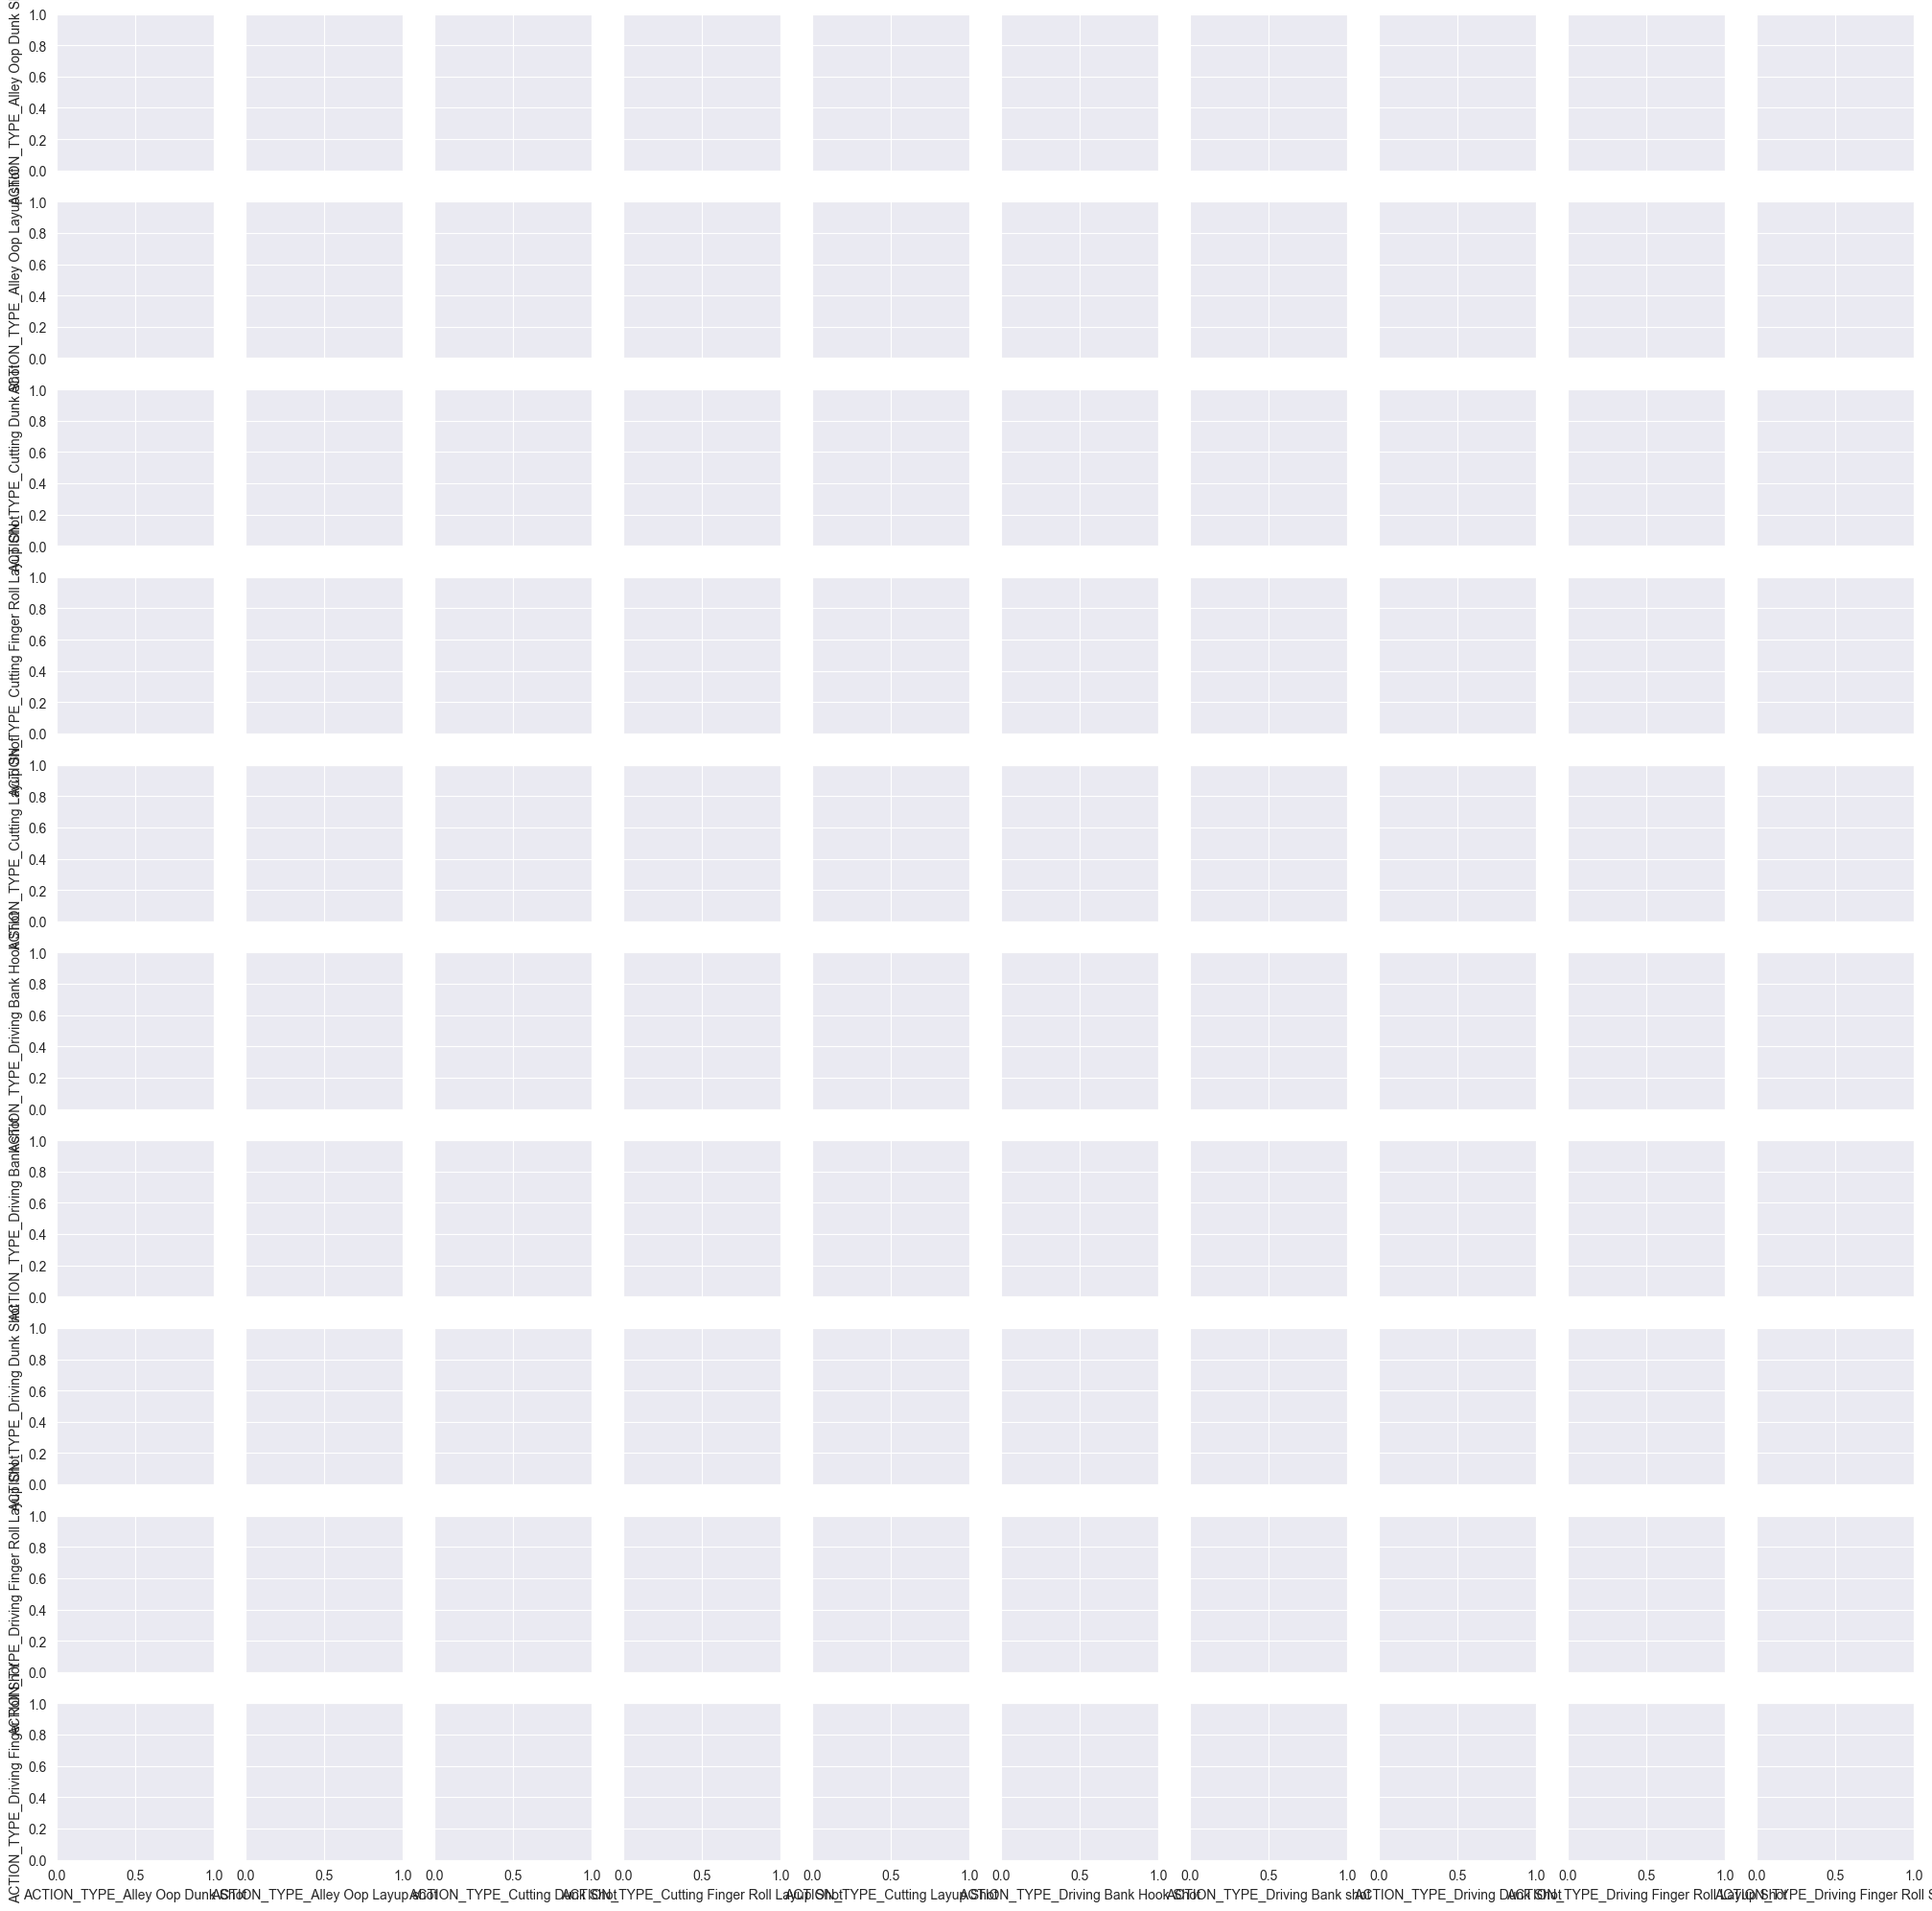

In [98]:
# Plot relationship between variables. We can see from the plots that the input variables are non-linear, e.g., LOC_X, LOC_Y. 
for_plot = train_df.iloc[:10000, :10]
sns.pairplot(for_plot, hue="SHOT_MADE")
plt.show()

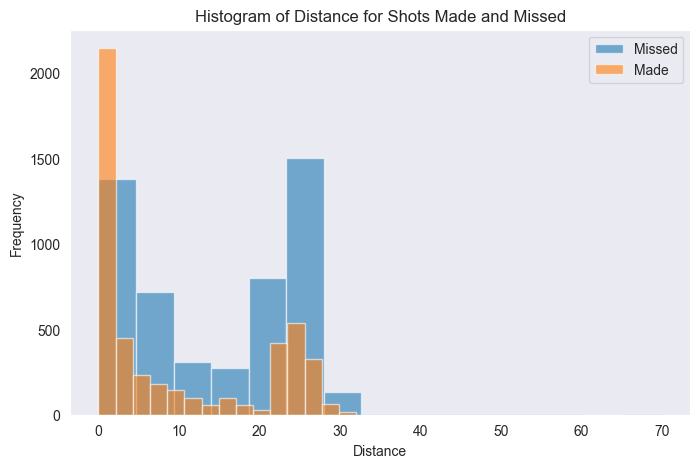

In [99]:
# Check if there is a relationship between distance and whether a shot is made
# based on plot we can see that the frequency of shots made is much higher when 
# the distance shorter compared to missed
sample_df = train_df[["SHOT_DISTANCE", "SHOT_MADE"]].iloc[:10000]
plt.figure(figsize=(8, 5))
sample_df[sample_df['SHOT_MADE'] == 0]['SHOT_DISTANCE'].hist(alpha=0.6, label='Missed', bins=15)
sample_df[sample_df['SHOT_MADE'] == 1]['SHOT_DISTANCE'].hist(alpha=0.6, label='Made', bins=15)
plt.title('Histogram of Distance for Shots Made and Missed')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

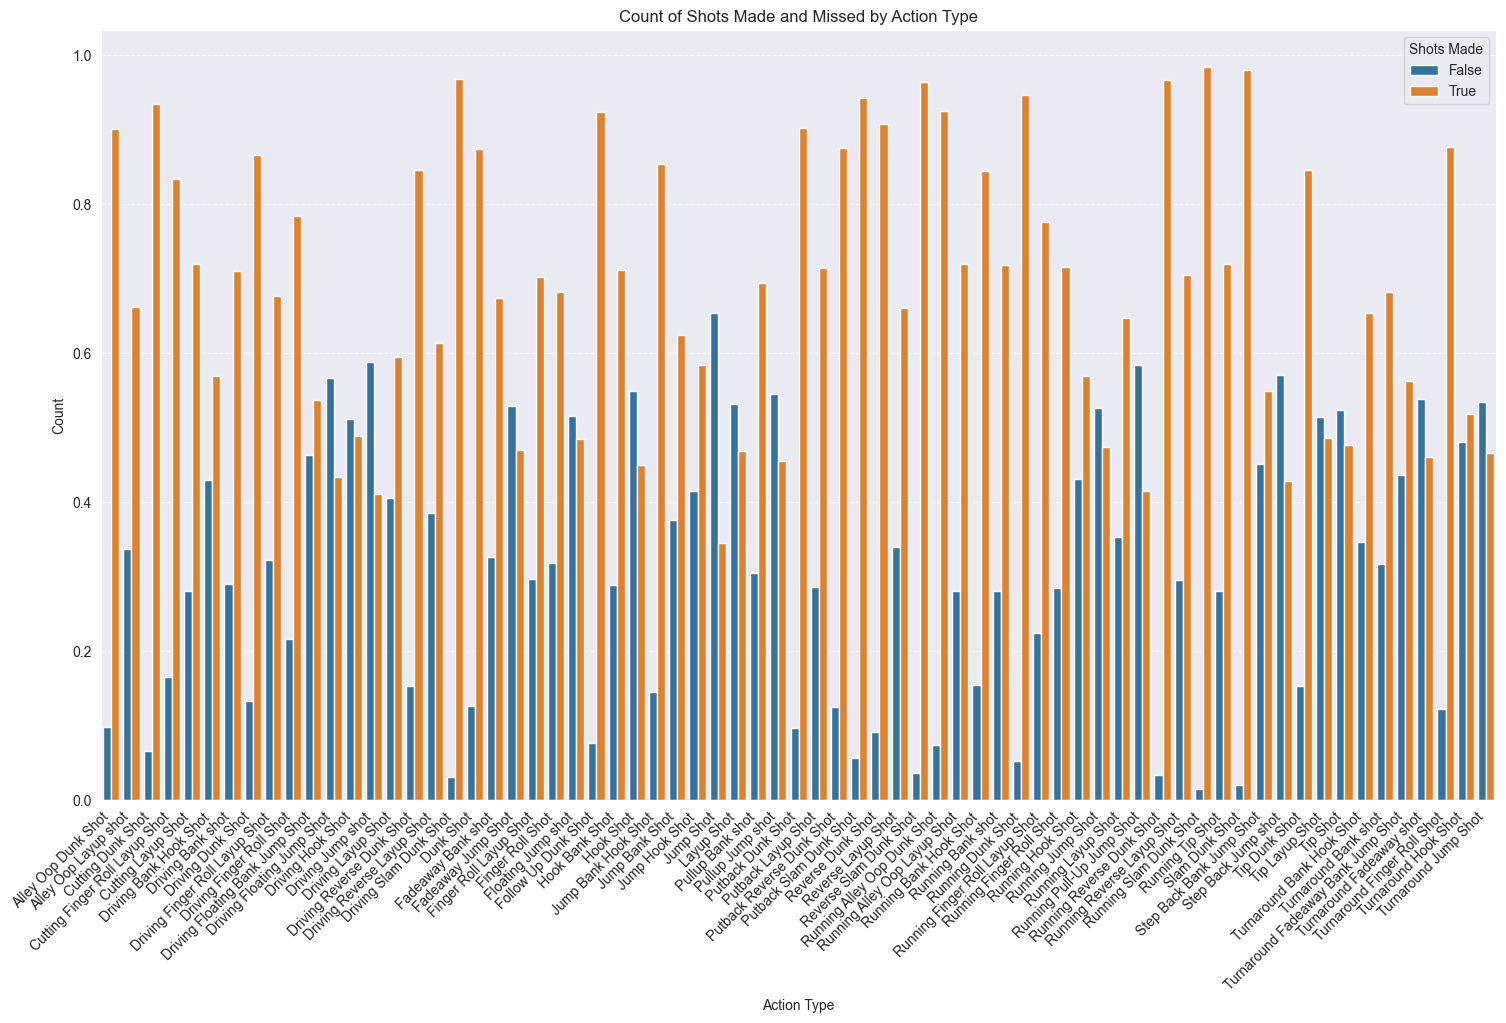

In [137]:
normalized_data = (
    df_shots_clean
    .groupby(['ACTION_TYPE', 'SHOT_MADE'])
    .size()
    .reset_index(name='count')
)
total_counts = normalized_data.groupby('ACTION_TYPE')['count'].transform('sum')
normalized_data['proportion'] = normalized_data['count'] / total_counts
plt.figure(figsize=(18, 10))
sns.barplot(
    data=normalized_data,
    x='ACTION_TYPE',
    y='proportion',
    hue='SHOT_MADE'
)
plt.title('Count of Shots Made and Missed by Action Type')
plt.xlabel('Action Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Shots Made')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Model Choice
## AdaBoost Classifier vs Deep Neural Network

The reason why we choose this model. It achieves similar accuracy scores and metrics compared to a deep neural network, therefore, we'll proceed with finetuning a AdaBoost Classifier because it's more computationally less expensive to run. Here we plot different performance metrics for each model. It seems like the AdaBoost is able to achieve better accuracy overall. It can generalize better the neural network. Based on the confustion matrix the neural network seems to be more bias towards predicting that a shot will not be a made.

In [101]:
estimator = AdaBoostClassifier(algorithm="SAMME")
params = {'n_estimators' : [50, 100, 200, 500, 1000]}
grid_search = GridSearchCV(estimator=estimator, param_grid=params, cv=10, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(cross_validation_subset_x_svd, cross_validation_subset_y)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 50}
Best Score:  0.5287


In [102]:
print(x_train_svd.shape)
print(y_train.shape) 

(1060727, 12)
(1060727,)


[CV] END ....................................n_estimators=50; total time=   0.7s
[CV] END ...................................n_estimators=100; total time=   2.0s
[CV] END ...................................n_estimators=200; total time=   3.2s
[CV] END ...................................n_estimators=500; total time=   6.9s
[CV] END ....................................n_estimators=50; total time=   0.7s
[CV] END ...................................n_estimators=100; total time=   1.9s
[CV] END ...................................n_estimators=200; total time=   3.3s
[CV] END ...................................n_estimators=500; total time=   7.0s
[CV] END ....................................n_estimators=50; total time=   0.7s
[CV] END ...................................n_estimators=100; total time=   1.9s
[CV] END ...................................n_estimators=200; total time=   3.4s
[CV] END ..................................n_estimators=1000; total time=  12.8s
[CV] END ...................

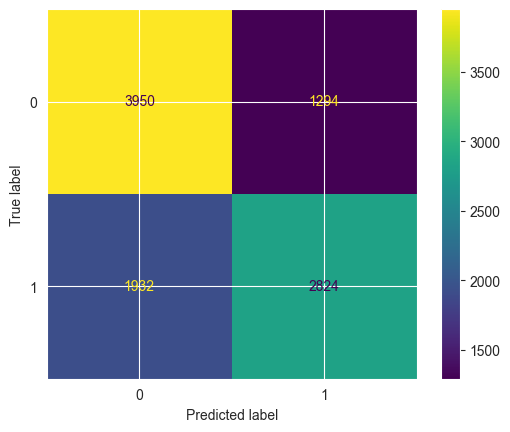

In [103]:

# Fitting an AdaBoostClassifier achieves a better score here
# rather then using fine tunning

model = AdaBoostClassifier()
model.fit(x_train, y_train)

preds = model.predict(x_test[:10000])
y_test_subset = y_test[:10000]
conf_matrix = confusion_matrix(y_test_subset, preds)

print(classification_report(y_test_subset, preds))
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot();

              precision    recall  f1-score   support

           0       0.51      0.58      0.54      5151
           1       0.48      0.41      0.44      4849

    accuracy                           0.50     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.50      0.49     10000


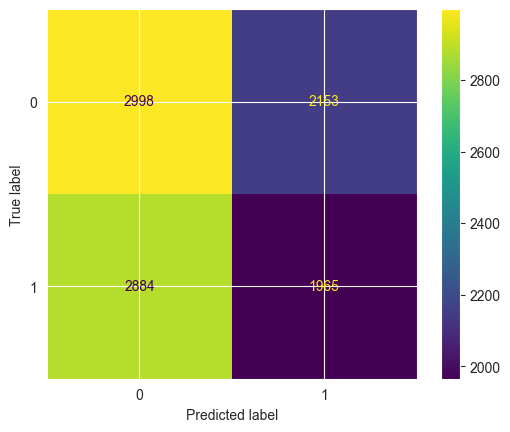

In [104]:
# Load FNN Model with best weights
model = FNN(input_dim).to(device)
model.load_state_dict(torch.load("best_fnn_model.pth", weights_only=True))

model.eval()
y_true, y_pred = [], []
for i in range(len(cross_validation_subset_x_svd)):
    x, y = cross_validation_subset_x_svd[i], cross_validation_subset_y.iloc[i]
    with torch.no_grad():
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)
        pred = model(x)
        predicted = (pred >= 0.5).float()
        y_true.append(y), y_pred.append(predicted.cpu())

print(classification_report(y_true, preds))
conf_matrix = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot();